# Data Science test case part 2

Task:For each unique vessel arrival (i.e. each row in the data), we would like a prediction of how much it transships (total of load & discharge activities) per cargo type. 

Main steps:
1. data preprocessing including check data types, columns, missing values, and calculate transships
2. data relationship analysis including a correlation test between factors and transships.
3. data modeling and accuracy assessment. I chose linear regression and random forest model. The dataset in the random forest model were not standardized due to the time limit.


# 1. Data preprocessing

In [107]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [108]:
df = pd.read_excel('Q:\quinyx_test\VesselData.xlsx')

#check the data shape
df.shape

(8208, 22)

In [109]:
##check the raw data and find there are some missing values
print(df)

                         eta                     ata                     atd  \
0     2017-09-19 00:00:00+00  2017-09-19 00:00:00+00  2017-09-22 00:00:00+00   
1     2017-10-02 00:00:00+00  2017-10-02 00:00:00+00  2017-10-03 00:00:00+00   
2     2017-09-30 00:00:00+00  2017-09-30 00:00:00+00  2017-10-01 00:00:00+00   
3     2017-10-02 00:00:00+00  2017-10-02 00:00:00+00  2017-10-03 00:00:00+00   
4     2017-10-02 00:00:00+00  2017-10-02 00:00:00+00  2017-10-02 00:00:00+00   
...                      ...                     ...                     ...   
8203  2017-11-03 00:00:00+00  2017-11-03 00:00:00+00  2017-11-04 00:00:00+00   
8204  2017-11-04 00:00:00+00  2017-11-04 00:00:00+00  2017-11-06 00:00:00+00   
8205  2017-11-08 00:00:00+00  2017-11-07 00:00:00+00  2017-11-11 00:00:00+00   
8206  2017-11-10 00:00:00+00  2017-11-10 00:00:00+00  2017-11-10 00:00:00+00   
8207  2017-11-10 00:00:00+00  2017-11-08 00:00:00+00  2017-11-10 00:00:00+00   

      vesseldwt  vesseltype  discharge1

In [110]:
##set variables of interest 
variables=['discharge1', 'load1','discharge2', 'load2', 'discharge3', 'load3', 'discharge4', 'load4']
#check the columns names
df.columns

Index(['eta', 'ata', 'atd', 'vesseldwt', 'vesseltype', 'discharge1', 'load1',
       'discharge2', 'load2', 'discharge3', 'load3', 'discharge4', 'load4',
       'stevedorenames', 'hasnohamis', 'earliesteta', 'latesteta',
       'traveltype', 'previousportid', 'nextportid', 'isremarkable',
       'vesselid'],
      dtype='object')

In [111]:
#check nan values
df.isnull().values.any()

True

In [112]:
df.isnull().sum()
#it shows vesseldwt and stevedorenames has NaN value. Hasnohamis shall be removed since it does not have valid values.

eta                  0
ata                  0
atd                  0
vesseldwt            2
vesseltype           0
discharge1           0
load1                0
discharge2           0
load2                0
discharge3           0
load3                0
discharge4           0
load4                0
stevedorenames       2
hasnohamis        8208
earliesteta          0
latesteta            0
traveltype           0
previousportid       0
nextportid           0
isremarkable         0
vesselid             0
dtype: int64

In [113]:
df2=df.drop('hasnohamis', axis=1) #remote Hasnohamis column
df2=df2.dropna() #remove raws that contain other missing values.
df2.shape #check the data shape again
df2.isnull().values.any() #check is there any missing values again.

False

In [114]:
#transships (total of load & discharge activities) per cargo type
#We can find we have four cargo types
for i in range(1,int(len(variables)/2)+1):
    newname='transships'+str(i)
    tmp1='discharge'+str(i)
    tmp2='load'+str(i)
    df2[newname]=df2[tmp1]+df2[tmp2]
    
df2.shape #check the data shape again
df2.columns[-4:] #check the new columns name

Index(['transships1', 'transships2', 'transships3', 'transships4'], dtype='object')

In [115]:
f_columns=['transships1', 'transships2', 'transships3', 'transships4']
df2[f_columns].describe().transpose() #show data statistical information

,count,mean,std,min,25%,50%,75%,max
transships1,8204.0,1785.306558,16343.301052,0.0,0.0,0.0,0.0,204304.0
transships2,8204.0,1188.665041,11351.391428,0.0,0.0,0.0,0.0,189933.0
transships3,8204.0,4838.435275,25890.594274,0.0,0.0,0.0,0.0,536978.0
transships4,8204.0,3325.864091,15763.734466,0.0,0.0,0.0,0.0,293449.0


In [116]:
#automatically detect datatime type in the dataframe and change object type to datatime type
data = [pd.to_datetime(df2[x]) if df2[x].astype(str).str.match(r'\d{4}-\d{2}-\d{2} \d{2}\:\d{2}\:\d{2}').all() else df2[x] for x in df2.columns]
df2 = pd.concat(data, axis=1, keys=[s.name for s in data])

#convert text to string type
info_text=['vesseltype', 'stevedorenames', 'traveltype', 'previousportid', 'nextportid', 'isremarkable', 'vesselid']
df2[info_text].astype(str)

##check if the data types have been converted successfully
df2.dtypes

eta               datetime64[ns, UTC]
ata               datetime64[ns, UTC]
atd               datetime64[ns, UTC]
vesseldwt                     float64
vesseltype                      int64
discharge1                      int64
load1                           int64
discharge2                      int64
load2                           int64
discharge3                      int64
load3                           int64
discharge4                      int64
load4                           int64
stevedorenames                 object
earliesteta       datetime64[ns, UTC]
latesteta         datetime64[ns, UTC]
traveltype                     object
previousportid                  int64
nextportid                      int64
isremarkable                   object
vesselid                        int64
transships1                     int64
transships2                     int64
transships3                     int64
transships4                     int64
dtype: object

# 2. Data Relationship analysis

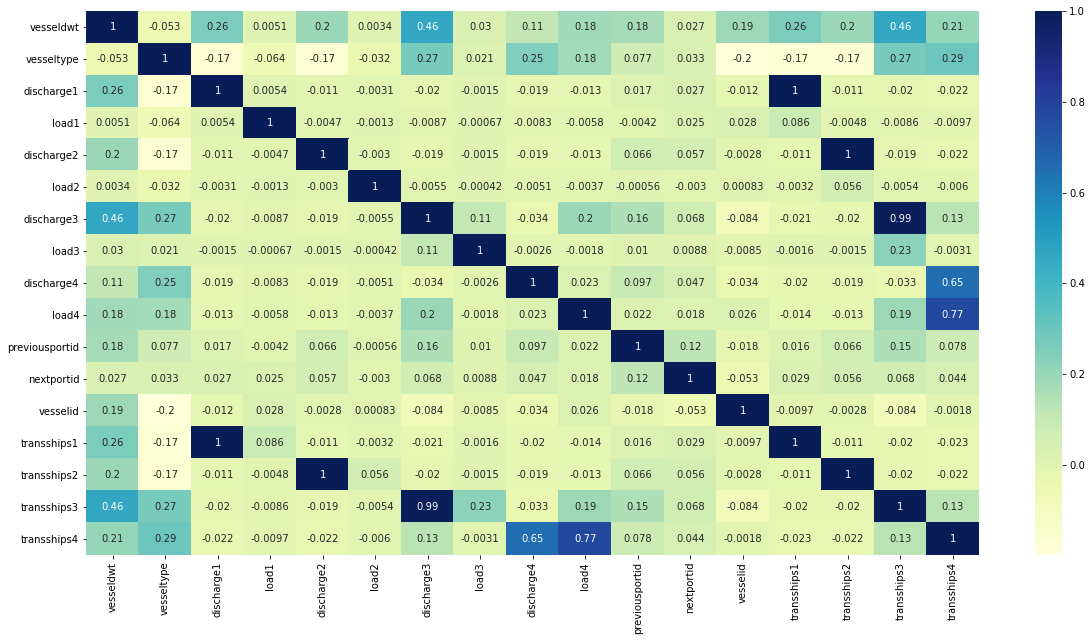

In [117]:
#before we model the data, we should check relationships between factors and depedent variables.
#Then we can select important factors in the model based on the correlation test.
plt.figure(figsize=(20,10))
correlations=df2.corr()
sns.heatmap(correlations, annot=True, cmap="YlGnBu")
#there is a moderate correlation between transships and vesseldwt.
#we can find vesseldwt is correlated with transships, especially with trainships3. The correlation coefficient reach 0.46

In [118]:
#I eventually chose vesseldwt and vesseltype as input factors for modeling
chose_factors=['vesseldwt','vesseltype']

# 3. Data modeling and accuracy evaluation

In [119]:
#I chose two models: linear regression and random forest. Because linear regression is a simple model for time series analysis.
#Random Forest is a robust model for time series analysis.
#Lastly, I compare the accuracy of these two models.
#The dataset in the random forest model was not standardized due to the time limit.
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression()

In [120]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

In [121]:
#use 70% percent as training test, 30% percent of the data as validation
#df2.index=df2.ata
train_size=int(len(df2)*0.7)
test_size=len(df2)-train_size
train=df2.iloc[0:train_size]
test=df2.iloc[train_size:len(df2)]
print(train.shape, test.shape) #check the data shape and make sure the length of the column is 25. 

(5742, 25) (2462, 25)


In [122]:
#split X and Y dataset
X_train,y_train = train[chose_factors],train['transships3']
X_test,y_test = test[chose_factors],test['transships3']
print(X_train.shape, y_train.shape) #check shape again
print(X_test.shape, y_test.shape)

(5742, 2) (5742,)
(2462, 2) (2462,)


In [123]:
print(X_train)

      vesseldwt  vesseltype
0      109290.0           5
1       67170.0           3
2       67737.0           3
3       43600.0           3
4        9231.0           3
...         ...         ...
5741   184320.0           3
5742     8565.0           3
5743     9231.0           3
5744     6600.0           3
5745    11253.0           3

[5742 rows x 2 columns]


In [124]:
##fit linear regression model
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression()
lin_model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)

LinearRegression()

In [125]:
##fit Random forest model
from sklearn.ensemble import RandomForestRegressor
rf_model=RandomForestRegressor(n_estimators=100,max_features=2, random_state=1)
rf_model.fit(X_train,y_train)

RandomForestRegressor(max_features=2, random_state=1)

In [126]:
##get prediction values for validation(X_test) data
ypred_lin=lin_model.predict(X_test) #use linear regression
ypred_rf=rf_model.predict(X_test) #use random forest

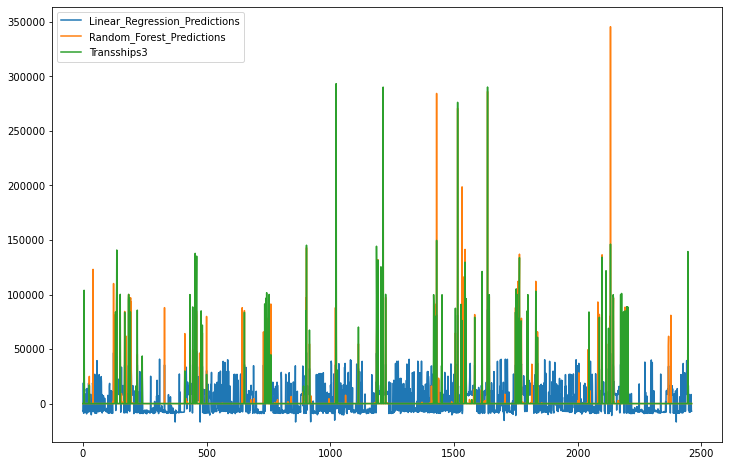

In [127]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
dt=pd.DatetimeIndex(test['ata'])
plt.plot(ypred_lin,label='Linear_Regression_Predictions')
plt.plot(ypred_rf,label='Random_Forest_Predictions')
y_test.index=np.arange(0, len(y_test))
plt.plot(y_test,label='Transships3')
plt.legend(loc="upper left")
plt.show()

In [128]:
#model accuracy assessment
from sklearn.metrics import mean_squared_error
from math import sqrt
import sklearn.metrics as metrics
def accuracytest(ypred_rf,y_test,method):
    accuracy=[
    ('rmse',metrics.mean_squared_error(ypred_rf,y_test)),
    ('r2',metrics.r2_score(ypred_rf,y_test)),
    ('mean_absolute_error',metrics.mean_absolute_error(ypred_rf,y_test)),
    ('median_absolute_error',metrics.median_absolute_error(ypred_rf,y_test)),
    #('mean_absolute_percentage_error',metrics.mean_absolute_percentage_error(ypred_rf,y_test)),
    ('explained_variance_score',metrics.explained_variance_score(ypred_rf,y_test))
    ]
    print(method)
    for cname, cvalues in accuracy:
        print(f"{cname:>15s}: {cvalues: >9.5f}")

In [129]:
accuracytest(ypred_rf,y_test,'Random_Forest:')

Random_Forest:
           rmse: 155252679.71903
             r2:   0.68056
mean_absolute_error: 2113.92853
median_absolute_error:   0.00000
explained_variance_score:   0.68088


In [130]:
accuracytest(ypred_lin,y_test,'Linear_Regression:')

Linear_Regression:
           rmse: 343993365.74950
             r2:  -0.72782
mean_absolute_error: 12147.61783
median_absolute_error: 8217.60552
explained_variance_score:  -0.72777


In [131]:
#randomforest model seems provide a better predictionl according to the errors assessment. 
#However, the model still need to be adjusted and detail in the model such as seasonality shall be updated in future 
#I am going to plot the time-series data with both actual and predicted data. But I don't have time to do it. 